<a href="https://colab.research.google.com/github/JairEsc/Mat_Apl/blob/main/Opt_Proyecto_derivative_free.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Idea general del algoritmo.

Input: 


*   $f:\mathbb{R}^n⟶ \mathbb{R}$, función objetivo.
*   $x_0$, aproximación inicial.
*   $a_{max}$, Número máximo de iteraciones para la busqueda en linea.
*   $\zeta$, parámetro de curvatura.
*   $tol_g$, criterio de paro para la norma del gradiente.



Descripción general del algoritmo

*   Calcular $f(x_0)$
*   Estimar $\epsilon_f$ usando ECnoise*
*   Calcular ** h
*   Calcular $\nabla_h f(x_0)$. Cuando se haga, guardar los valores $(x_s,f_s)$ que satisfacen $f_s=f(x_s)=min_{x\in S} f(x)$, $S=\{x+h\cdot e_i,i=1,\ldots,n\}$
*   While ($||\nabla f(x_k)||>tol_g$):
    *   Calcular $d_k=-H_k\nabla_h f(x_k)$ usando L-BFGS***
    *   Hacer line_search$(x_k,f_k,\nabla_h f(x_k),d_k,a_{max})$ y obtiene $(x_+,f_+,\alpha_k,LS_{flag})$
        *   If($LS_{flag}==1$):
            *   Invocar Recovery($x_s,f_s$)
        *   Else:
            *   Actualizar $x_{k+1}=x_+,$ $f_{k+1}=f_+$
    *   Calcular $\nabla_h f(x_{k+1})$ y guardar $(x_s,f_s)$
    *   Calcular $s_k=x_{k+1}-x_k$, $y_k=\nabla_h f(x_{k+1})-\nabla_h f(x_k)$
        *   Guardarlos si $s_k^Ty_k\geq \zeta||s_k||||y_k||$

Explicación de L-BFGS:
Si $H_k$ es una aproximación de la inversa del Hessiano, nos interesa caluclar $d_k=-H_k\nabla f(x_k)$.


Input:



*   $\nabla f(x_k)$
*   $\{(s_{k-1},y_{k-1}),(s_{k-2},y_{k-2}),\ldots,(s_{k-m},y_{k-m})\}$
*   $H^0_{k-m}$

Algoritmo:


*   Define $q=\nabla f(x_k)$
*   for $i=1,2,\ldots,m$ do:
    *   Calcular $\alpha_i=\rho_i s_{k-i}^Tq$
    *   Actualiza $q=q-\alpha_iy_i$
*   Define $r=H^0_{k-m}q$
*   for $i=1,2,\ldots,m$ do:
    *   Calcular $\beta=\rho_{k-i}y_{k-i}^Tr$
    *   Actualiza $r=r-s_{k-i}(\alpha_i-\beta)$
*   $r$ es una aproximación de $H_k\nabla f(x_k)$


In [50]:
import numpy as np
import scipy.optimize

In [205]:
try:
  www=1/0
except:
  print("An exception occurred")

An exception occurred


In [51]:
def L_BFGS(S,Y,g):#Checar las posibles divisiones por cero
    n=len(g)
    m=len(S)
    #supondremos H_0 un multiplo de la identidad
    H_0=(np.dot(S[-1],Y[-1])/(np.dot(Y[-1],Y[-1])))*np.identity(n)#Dado en clase.
    q=g
    alphas=[]
    for i in range(m):
        alphas.append()*np.dot(S[-i],q))
        q=q-alphas[i]*Y[-i]
    r=np.dot(H_0,q)
    for i in range(m):
        beta=(1/np.dot(Y[-i],S[-i]))*np.dot(Y[-i],r)
        r=r+S[-i]*(alphas[i]-beta)#aproximacion de -H*g
    return r

In [52]:
def ECNoise(F):#F es un vector que guarda f(t_i), i=0,...,m. Evaluaciones de m+1 puntos equiespaciados
    m=len(F)-1
    T=np.zeros((m+1,m+1))
    for i in range(m+1):
        T[i,0]=F[i]
    for k in range(m):
        for i in range(m-k):
            T[i,k+1]=T[i+1,k]-T[i,k]
    return T

In [53]:
def var_estimation(T):#Recibe la tabla.
    m=len(T)-1
    sigma_array=[]
    for k in range(1,m):
        sigma_array.append(((np.math.factorial(k)/np.math.factorial(2*k))/(m+1-k))*np.sum(T.T[k]**2))
    #Ahora checamos las 2 condiciones.
    for k in range(1,m-2):
        max_k=np.max(sigma_array[k:k+2])
        min_k=np.min(sigma_array[k:k+2])
        if(max_k<=4*min_k):
            if(np.sign(min_k*max_k)==-1):
                print("es el ", k)
                break
    return np.sqrt(sigma_array[k])#Podria ser que las condiciones no se cumplan, en tal caso regresa la ultima estimacion sigma.

In [90]:
def aprox_f_biprima(e_f,f,x_k,p):#Usando una direccion (aleatoria dada) se aproxima el max ||Hessiana_f(x_k)*p||
    tao_1=100
    tao_2=0.1
    h_a=e_f**(1/4)
    f_mas=f(x_k+h_a*p)
    f_menos=f(x_k-h_a*p)
    f_0=f(x_k)
    delta_h_a=abs(f_mas+f_menos-2*f_0)
    mu_a=delta_h_a/(h_a**2)
    if(delta_h_a/e_f>=tao_1):
        mu=mu_a
        if(abs(f_mas-f_0)<=tao_2*max(f_mas,f_menos,f_0) and abs(f_menos-f_0)<=tao_2*max(f_mas,f_menos,f_0)):
            return mu_a
    h_b=(e_f/mu_a)**(1/4)
    f_mas=f(x_k+h_b*p)
    f_menos=f(x_k-h_b*p)
    delta_h_b=abs(f_mas+f_menos-2*f_0)
    mu_b=delta_h_b/(h_b**2)
    if(delta_h_b/e_f>=tao_1):
        mu=mu_b
        if(abs(f_mas-f_0)<=tao_2*max(f_mas,f_menos,f_0) and abs(f_menos-f_0)<=tao_2*max(f_mas,f_menos,f_0)):
            return mu_b
    if(abs(mu_a-mu_b)<=0.5*mu_b):
        return mu_b
    print("No hay regla de decision")
    return mu_b


In [227]:
np.random.seed(1)
x_k=np.random.uniform(0,1,size=100)
print(Rosembrok_grad(x_k))
print(scipy.optimize.approx_fprime(xk=x_k,f=Rosembrok,epsilon=10**(-4)))

[ -92.31314461  258.19227427 -105.76420315   52.37742429    5.20748972
    5.78026229   10.7583541    22.52745973   -6.2650381    47.58094506
  -60.81848335  173.92294723 -123.00053176  428.24287955 -158.022532
  141.92591042  -71.79901191  114.40809274  -46.08632195  -26.2669405
   47.14184487  307.06972556 -200.67501657    8.23964165   34.80611872
  281.0555388  -145.96780556    1.81331428  -25.69410957  405.937604
 -152.54614333  -50.35023279  303.30749752 -164.74088723  126.06586802
 -108.08149331   16.98927599  298.79223596 -143.11086264   21.59428109
  176.05552411   37.147629   -137.01750413  305.79136342 -123.794448
  -40.49772767  334.73884784 -131.47215972   33.45396328    7.57491889
   -6.72524643  202.71325425  -70.1022828    -2.04109874  120.21644997
  -51.74336948  155.40065778  -71.60663358   29.64712329  178.30920146
  -95.78099889   -7.06868036  122.87146304    5.37008664  -36.87638589
   25.02249323   54.93063565 -126.06062234  251.29261959 -193.2047537
  356.91903565

In [149]:
#Usare sccipy.optimize.line_search() para la busqueda en linea.

In [113]:
def Rosembrok(X):#X es un vector.
    return (np.sum(100*(X[1:]-X[:-1]**2)**2+(1-X[:-1])**2)+10**(-3)*np.random.uniform(0,1))
def Rosembrok_grad(X):
    n=len(X)
    grad=np.zeros(n)
    grad[1:-1]=-400*X[1:-1]*(X[2:]-X[1:-1]**2)+200*(X[1:-1]-X[:-2]**2)-2*(1-X[1:-1])
    grad[0]=-400*X[0]*(X[1]-X[0]**2)-2*(1-X[0])
    grad[-1]=200*(X[-1]-X[-2]**2)
    return grad

In [219]:
def relaxed_Wolfe(x_k,f,fprime,d,e_f,c_1=0.001,c_2=0.9,max_iter=10**4):
    iter=0
    alpha_0=1
    alpha=0
    grad_f_k=fprime(x_k)
    f_k=f(x_k)
    beta=np.inf
    alpha_i=alpha_0
    for i in range(max_iter):
        if(f(x_k+alpha_i*d)>f_k+c_1*alpha_i*np.dot(grad_f_k,d)+2*e_f):
            beta=alpha_i
            alpha_i=0.5*(alpha+beta)
        else:
            if(np.dot(fprime(x_k+alpha_i*d),d)<c_2*np.dot(grad_f_k,d)):
                alpha=alpha_i
                if(beta==np.inf):
                    alpha_i=2*alpha
                else:
                    0.5*(alpha+beta)
            else:
                break
    return alpha_i
    

In [217]:
from numpy.core.fromnumeric import amax
import matplotlib.pyplot as plt

def find_minimum(f,x_0,m,a_max,zeta,tol_g,max_iter=10**2):
    f_0=f(x_0)
    n=len(x_0)
    p=np.eye(1,n,np.random.randint(0,n))
    delta=10**(-3)#Suggested by ECnoise algorithm.
    F=[f(x_0+delta*i*p) for i in range(m)]
    T=ECNoise(F)
    e_f=var_estimation(T)
    print("e_f: ",e_f)#Breakpoint
    mu=aprox_f_biprima(e_f=e_f,f=f,x_k=x_0,p=p)
    h=(8**(1/4))*(e_f/mu)**(1/2)
    print("h: ", h)
    X_s=np.zeros((m,n))
    F_s=np.zeros(m)
    g_0=scipy.optimize.approx_fprime(f=f,xk=x_0,epsilon=h)
    Y=[]
    S=[]
    def fprime(x):
        return scipy.optimize.approx_fprime(f=f,xk=x,epsilon=h)
    #print(g_0)
    iter=0
    alpha_k=relaxed_Wolfe(x_k=x_0,f=f,fprime=fprime,d=-g_0,e_f=e_f,c_1=0.001,c_2=0.9,max_iter=10**4)
    x_1=x_0-alpha_k*g_0
    f_k_m=f(x_1)
    g_1=fprime(x_1)
    Y.append(g_1-g_0)
    S.append(-alpha_k*g_0)
    iter=1
    FF=[f(x_0),f(x_1)]
    GG=[]
    while(np.linalg.norm(g_1)>tol_g and iter<max_iter):
        x_0=x_1
        g_0=g_1
        d_k=L_BFGS(S=S,Y=Y,g=g_1)
        alpha_k=relaxed_Wolfe(x_k=x_0,f=f,fprime=fprime,d=d_k,e_f=e_f,c_1=0.001,c_2=0.9,max_iter=10**4)
        x_1=x_0+alpha_k*d_k
        f_k_m=f(x_1)
        g_1=fprime(x_1)
        Y.append(g_1-g_0)
        S.append(x_1-x_0)
        iter+=1
        FF.append(f(x_1))
        GG.append(np.linalg.norm(x_1))
    plt.plot(GG)
    print(GG[-2])##Antes del error
    return x_1

e_f:  9.526521142657172e-05
No hay regla de decision
h:  9.951112928237689e-07
3.483936614581426


array([ 0.15034287,  0.52740336,  0.40325759,  0.40489609,  0.24121057,
        0.07982371,  0.2776725 ,  0.63161937,  0.29434315,  0.75076872,
        0.61278552,  0.47329782,  0.3902654 ,  0.36937194, -0.29919188,
       -0.24109215, -0.13223484,  0.23790127,  0.34820092,  0.76501483,
        1.07911488,  0.62224671,  0.10367141,  0.60924635, -0.04170152,
        0.42049486, -0.15579848,  0.52287746,  0.33157276, -0.11544631,
        0.11718991,  0.30144589,  0.35768922,  0.370265  , -0.14851654,
        0.20697025, -0.01780348,  0.14399803,  0.5688145 ,  0.60037981,
        0.07137052,  0.0677554 ,  0.3070741 , -0.14866077,  0.56725485,
        0.46849678, -0.23032533, -0.36982783,  0.14471337,  0.14198741,
        0.54830072,  0.63931954,  0.65647389, -0.06323852, -0.06535755,
       -0.1390968 ,  0.27059766,  0.06410061,  0.09415757,  0.18704451,
        0.1360345 ,  0.07021721, -0.12669444, -0.19860418, -0.1622805 ,
        0.25251658, -0.030504  ,  0.02402481,  0.50860628, -0.08

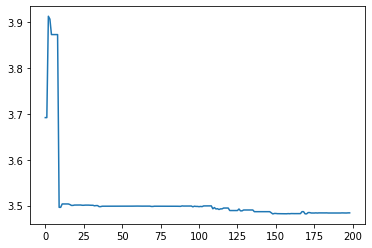

In [222]:
np.random.seed(0)
x_0=np.random.uniform(0,1,size=100)
find_minimum(f=Rosembrok,x_0=x_0,m=6,a_max=100,zeta=0.5,tol_g=10**(-2),max_iter=2*10**2)